# **Data Acquisition project**

# Step 1: Kaggle dataset

Downloading Kaggle datasets from : [usgs/earthquake-database](https://www.kaggle.com/datasets/usgs/earthquake-database)

In [ ]:
import kagglehub

# link: https://www.kaggle.com/datasets/usgs/earthquake-database


path = kagglehub.dataset_download("usgs/earthquake-database")

print("Path to dataset files:", path)

100%|██████████| 590k/590k [00:00<00:00, 91.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/usgs/earthquake-database/versions/1


### USGS Earthquake Database Description

This dataset contains earthquake records from the USGS (United States Geological Survey) database.
Key features include:
- **Time**: Timestamp of earthquake occurrence
- **Latitude/Longitude**: Geographic coordinates of earthquake epicenter
- **Depth**: Depth of earthquake in kilometers
- **Magnitude**: Earthquake magnitude (typically Richter or moment magnitude scale)
- **Location**: Text description of earthquake location

The dataset allows analysis of seismic patterns, magnitude distributions, and geographic clustering of earthquakes.

In [ ]:
import pandas as pd
import numpy as np

df_earthquakes = pd.read_csv(path + '/database.csv')


# Checking content
print("\nHeader :\n")
print(df_earthquakes.head())

# Column informations
print("\nInformations :\n")
print(df_earthquakes.info())


# Missing values
print("\nMissing values :\n")
print(df_earthquakes.isnull().sum())

if len(df_earthquakes) > 10000:
    df_earthquakes = df_earthquakes.sample(n=10000, random_state=42)
    print(f"\nDataset reduced to {len(df_earthquakes)} rows")


Header :

         Date      Time  Latitude  Longitude        Type  Depth  Depth Error  \
0  01/02/1965  13:44:18    19.246    145.616  Earthquake  131.6          NaN   
1  01/04/1965  11:29:49     1.863    127.352  Earthquake   80.0          NaN   
2  01/05/1965  18:05:58   -20.579   -173.972  Earthquake   20.0          NaN   
3  01/08/1965  18:49:43   -59.076    -23.557  Earthquake   15.0          NaN   
4  01/09/1965  13:32:50    11.938    126.427  Earthquake   15.0          NaN   

   Depth Seismic Stations  Magnitude Magnitude Type  ...  \
0                     NaN        6.0             MW  ...   
1                     NaN        5.8             MW  ...   
2                     NaN        6.2             MW  ...   
3                     NaN        5.8             MW  ...   
4                     NaN        5.8             MW  ...   

   Magnitude Seismic Stations  Azimuthal Gap  Horizontal Distance  \
0                         NaN            NaN                  NaN   
1        

# Step 2: Web Scrape a Complementary dataset


In [ ]:
from bs4 import BeautifulSoup
import numpy as np
import requests

# Step 2: Scrape the Pleistocene HTML table as backup
url = "https://volcano.si.edu/volcanolist_pleistocene.cfm"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

headers = {'User-Agent': 'Mozilla/5.0'}

# Get volcano list
url = "https://volcano.si.edu/volcanolist_pleistocene.cfm"
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract volcano names and links
volcanoes = []
table = soup.find('table')

for row in table.find_all('tr')[1:]:
    cols = row.find_all('td')
    if cols:
        link = cols[0].find('a')
        if link:
            volcanoes.append({
                'name': link.text.strip(),
                'url': 'https://volcano.si.edu/' + link['href']
            })

df_volcanoes_scraped = pd.DataFrame(volcanoes)
print(f"\nScraped {len(df_volcanoes_scraped)} volcanoes")
print(df_volcanoes_scraped.head())






Scraped 1427 volcanoes
                     name                                           url
0                     Aak  https://volcano.si.edu/volcano.cfm?vn=300830
1  Acatlan Volcanic Field  https://volcano.si.edu/volcano.cfm?vn=341822
2                Acoculco  https://volcano.si.edu/volcano.cfm?vn=341827
3                Acotango  https://volcano.si.edu/volcano.cfm?vn=355813
4             Acquasparta  https://volcano.si.edu/volcano.cfm?vn=211804


In [ ]:
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_volcano_data(volcano):
    # Get data for a single volcano
    try:
        response = requests.get(volcano['url'], headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Get coordinates
        table = soup.find('div', {'class': 'volcano-subinfo-table'})
        items = table.find_all('li', {'class': 'clear'})

        lat = items[0].text.strip()
        lat = float(lat.replace('°N', '').replace('°S', '').strip())
        if '°S' in items[0].text:
            lat = -lat

        lon = items[1].text.strip()
        lon = float(lon.replace('°E', '').replace('°W', '').strip())
        if '°W' in items[1].text:
            lon = -lon

        volcano_num = items[5].text.strip()

        # Get type
        info_table = soup.find('div', {'class': 'volcano-info-table'})
        shaded = info_table.find_all('li', {'class': 'shaded'})
        volcano_type = shaded[2].text.strip() if len(shaded) > 2 else None

        return {
            'name': volcano['name'],
            'latitude': lat,
            'longitude': lon,
            'type': volcano_type,
            'volcano_number': volcano_num,
            'status': 'success'
        }
    except Exception as e:
        return {
            'name': volcano['name'],
            'latitude': None,
            'longitude': None,
            'type': None,
            'volcano_number': None,
            'status': 'failed'
        }

print("Scraping volcano data with parallel processing...\n")

results = []
success = 0
failed = 0

# Use 10 parallel threads for faster volcanoes data retrievals
with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_volcano = {executor.submit(get_volcano_data, v): v for v in volcanoes}

    for future in as_completed(future_to_volcano):
        result = future.result()
        results.append(result)

        if result['status'] == 'success':
            success += 1

        else:
            failed += 1
            print(f"{result['name']} failed ({failed} total failures)")

# Remove status
df_volcanoes = pd.DataFrame(results)
df_volcanoes = df_volcanoes[df_volcanoes['status'] == 'success'].drop('status', axis=1)

# Display results
print(f"\n{'='*60}")
print(f"Successfully scraped: {success}")
print(f"Failed: {failed}")
print(f"{'='*60}\n")

print(df_volcanoes.head(10))

# Save to CSV
df_volcanoes.to_csv('volcano_data.csv', index=False)
print(f"\nSaved {len(df)} volcanoes to volcano_data.csv")


Scraping volcano data with parallel processing...

Chiquimula Volcanic Field failed (1 total failures)
Oshima Maruyama failed (2 total failures)
Oshima-Kojima failed (3 total failures)
Sergief failed (4 total failures)
Seulawah Agam failed (5 total failures)
Shahsavaran failed (6 total failures)
Seulawah Inong failed (7 total failures)
Shlen failed (8 total failures)
Siete Orejas failed (9 total failures)
Sibualbuali failed (10 total failures)
Sifford Mountain failed (11 total failures)
Sigurd failed (12 total failures)
Table Mountain failed (13 total failures)
Tablas, Cerro las failed (14 total failures)
Tabarin Peninsula failed (15 total failures)
Tosa Sucha failed (16 total failures)

Successfully scraped: 1411
Failed: 16

                       name  latitude  longitude  \
0                       Aak    53.380    158.670   
1                Adamozhets    54.688    159.483   
2                    Adachi    38.218    140.654   
3               Acquasparta    42.650     12.300   
4   

# Step 3: Merge

Spliting type column into two column:
- landform
- volcano_type

In [ ]:
df_volcanoes = pd.read_csv('volcano_data.csv')

df_volcanoes[['landform', 'volcano_type']] = df_volcanoes['type'].str.split('|', n=1, expand=True)

df_volcanoes['landform'] = df_volcanoes['landform'].str.strip()
df_volcanoes['volcano_type'] = df_volcanoes['volcano_type'].str.strip()

df_volcanoes = df_volcanoes.drop('type', axis=1)

print(df_volcanoes.head())

df_volcanoes.to_csv('volcano_data_clean.csv', index=False)

          name  latitude  longitude  volcano_number   landform  \
0          Aak    53.380    158.670          300830  Composite   
1   Adamozhets    54.688    159.483          300847      Minor   
2       Adachi    38.218    140.654          283874      Minor   
3  Acquasparta    42.650     12.300          211804    Cluster   
4     Acoculco    19.970    -98.200          341827    Caldera   

        volcano_type  
0  Stratovolcano(es)  
1               Cone  
2   Pyroclastic cone  
3     Volcanic field  
4            Caldera  


Calculate distance between two points on Earth in kilometers

Using the cKDTree : https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html

Merging data to assign nearest volcano to each earthquake

In [ ]:
from scipy.spatial import cKDTree
import numpy as np

print("Creating spatial index for ultra-fast lookups...\n")

# Convert volcano coordinates to radians
volcano_coords = np.radians(df_volcanoes[['latitude', 'longitude']].values)

# Spatial tree
tree = cKDTree(volcano_coords)


eq_coords = np.radians(df_earthquakes[['Latitude', 'Longitude']].values)
distances, volcano_indices = tree.query(eq_coords)
distances_km = (distances * 6371).round().astype(int)

# Add volcano information to earthquake dataframe
df_earthquakes['nearest_volcano_name'] = df_volcanoes.iloc[volcano_indices]['name'].values
df_earthquakes['nearest_volcano_landform'] = df_volcanoes.iloc[volcano_indices]['landform'].values
df_earthquakes['nearest_volcano_type'] = df_volcanoes.iloc[volcano_indices]['volcano_type'].values
df_earthquakes['distance_to_volcano_km'] = distances_km
df_earthquakes['volcano_number'] = df_volcanoes.iloc[volcano_indices]['volcano_number'].values

print("--- Merged Data ---")
print(df_earthquakes.head(10))

df_earthquakes.to_csv('earthquakes_with_volcanoes.csv', index=False)
print(f"Saved {len(df_earthquakes)} earthquakes to 'earthquakes_with_volcanoes.csv'")




Creating spatial index for ultra-fast lookups...

--- Merged Data ---
             Date      Time  Latitude  Longitude        Type  Depth  \
3848   02/22/1976  07:47:59     3.166     99.015  Earthquake  180.0   
14008  06/03/1998  15:47:08    43.679    -29.020  Earthquake   10.0   
16258  05/12/2003  03:03:05     1.142     98.911  Earthquake   77.6   
18090  10/26/2006  14:28:37    38.649     15.390  Earthquake  212.0   
15192  12/15/2000  16:44:48    38.457     31.351  Earthquake   10.0   
6381   12/19/1982  00:33:49   -32.555   -178.317  Earthquake   33.0   
18026  09/03/2006  22:57:31   -24.046    178.817  Earthquake  568.1   
5286   09/24/1979  06:40:46   -60.578    -50.306  Earthquake   10.0   
9427   04/16/1989  19:48:15   -21.039   -178.942  Earthquake  609.7   
7748   11/01/1985  22:02:26    18.226    146.427  Earthquake   78.0   

       Depth Error  Depth Seismic Stations  Magnitude Magnitude Type  ...  \
3848           NaN                     NaN        5.6             MB  .

In [ ]:
# Quick statistics
print("\n--- Statistics ---")
print(f"Average distance to nearest volcano: {distances_km.mean():.0f} km")
print(f"Min distance: {distances_km.min()} km")
print(f"Max distance: {distances_km.max()} km")
print(f"\nEarthquakes within 50km of a volcano: {(distances_km < 50).sum()}")


--- Statistics ---
Average distance to nearest volcano: 446 km
Min distance: 1 km
Max distance: 4283 km

Earthquakes within 50km of a volcano: 918


# Step 4: Explore / visualise

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('earthquakes_with_volcanoes.csv')

## First plot : Distribution of Distances

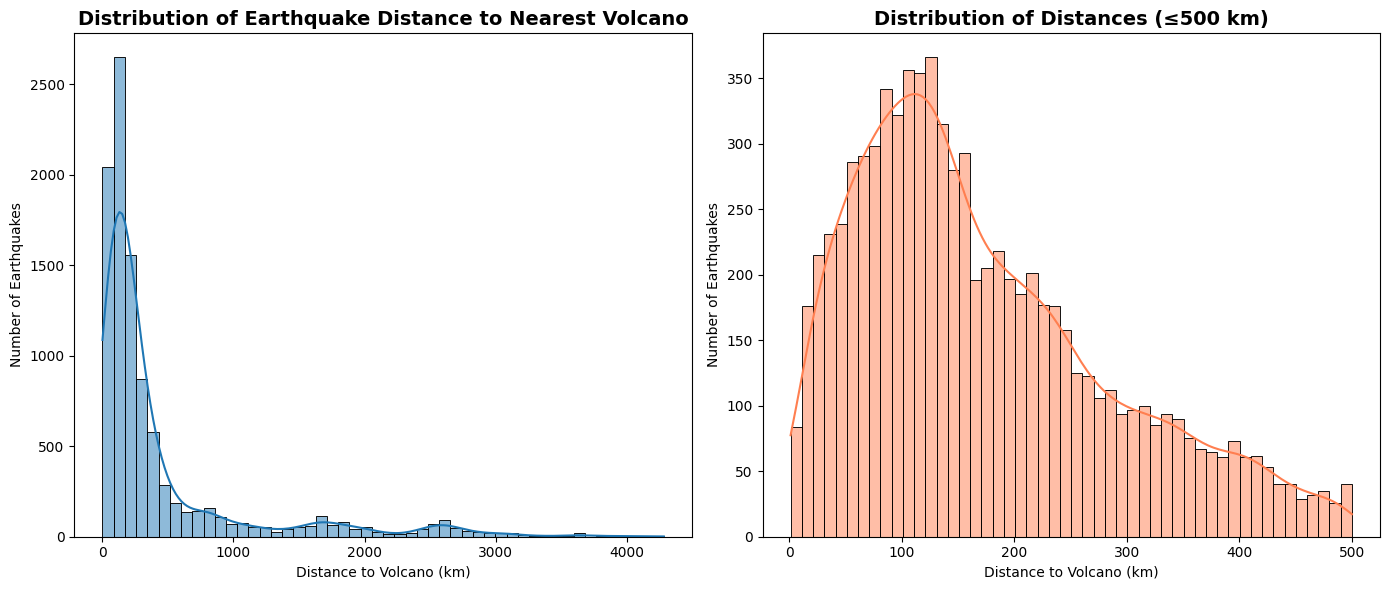

In [5]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='distance_to_volcano_km', bins=50, kde=True)
plt.title('Distribution of Earthquake Distance to Nearest Volcano', fontsize=14, fontweight='bold')
plt.xlabel('Distance to Volcano (km)')
plt.ylabel('Number of Earthquakes')

plt.subplot(1, 2, 2)
# Focus on earthquakes within 500km
df_close = df[df['distance_to_volcano_km'] <= 500]
sns.histplot(data=df_close, x='distance_to_volcano_km', bins=50, kde=True, color='coral')
plt.title('Distribution of Distances (≤500 km)', fontsize=14, fontweight='bold')
plt.xlabel('Distance to Volcano (km)')
plt.ylabel('Number of Earthquakes')

plt.tight_layout()
plt.show()

Second plot : Magnitude vs Distance

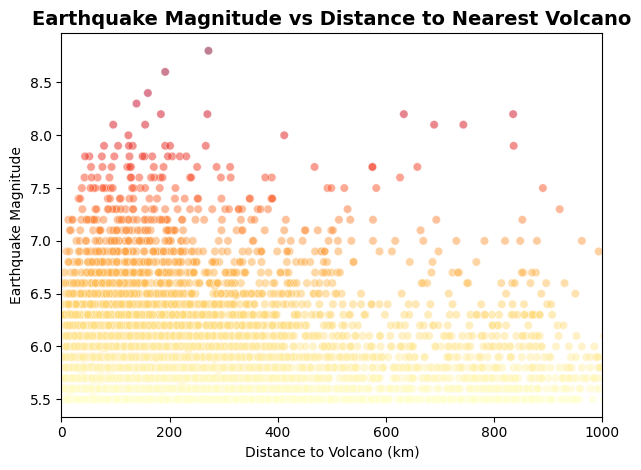

In [8]:
sns.scatterplot(data=df, x='distance_to_volcano_km', y='Magnitude',
alpha=0.5, hue='Magnitude', palette='YlOrRd', legend=False)
plt.title('Earthquake Magnitude vs Distance to Nearest Volcano', fontsize=14, fontweight='bold')
plt.xlabel('Distance to Volcano (km)')
plt.ylabel('Earthquake Magnitude')
plt.xlim(0, 1000)

plt.tight_layout()
plt.show()